In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

In [51]:
import torch
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms

%load_ext autoreload

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def load_data(train, shuffle):
    ds = datasets.MNIST(root='./data/.cache', train=train, transform=transform, download=True)
    loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=shuffle)
    all_data = []
    for data, labels in loader:
        all_data.append((data, labels))
    return all_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
train_data = load_data(True, False)
test_data = load_data(False, False)

label: 5


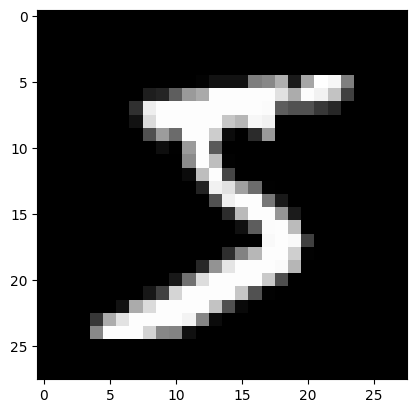

In [53]:
import matplotlib.pyplot as plt

img, label = train_data[0]

print(f'label: {label.item()}')
plt.imshow(img[0].squeeze(), cmap='gray');


In [54]:
import numpy as np
import torch.nn.functional as F
import sys

from simplenn import nn

%autoreload 2

def transform_data(data, targets):
    data = data.numpy().squeeze().reshape(data.shape[0], 784)
    targets = targets.numpy().reshape(data.shape[0], 1)
    y = np.zeros((targets.size, 10))
    y[np.arange(targets.shape[0]), targets.T] = 1
    return data, y

def transform_all(data):
    x = data.copy()
    for i in range(len(data)):
        x[i] = transform_data(*data[i])
    return x


def create_batches(data, size):
    batches = []
    for i in range(0, len(data), size):
        batch = data[i:i+size]
        x, y = tuple(zip(*batch))
        batches.append((np.concatenate(x, axis=0), np.concatenate(y, axis=0)))
    return batches
        

train = transform_all(train_data)
test = transform_all(test_data)


In [55]:
import scipy

fnn = nn.Sequential([
    nn.LinearLayer(784, 50),
    nn.Relu(),
    nn.LinearLayer(50, 10),
    # TODO(d): figure out how to deal with softmax and cross-entropy
#     nn.Softmax(axis=0),
])

batch_size = 32
max_samples = 60000

train_batches = create_batches(train[:max_samples], batch_size)
test_batches = create_batches(test[:max_samples], batch_size)

epochs = 10
lr = 1e-2

avg_loss = 0
for n in range(epochs):
    epoch_loss = 0
    for x, y in train_batches:
        logits = fnn.forward(x)
        probs = scipy.special.softmax(logits, axis=1)
        loss = -1/len(probs) * np.sum(y * np.log(probs+1e-10))
        epoch_loss += loss
        grad = probs - y
        fnn.backward(grad)
        fnn.update_params(lr)
    avg_loss = epoch_loss / len(train_batches)
    print(f'{n}: {avg_loss}')

print(f'Training loss: {avg_loss}')    

0: 3.8967132018472164
1: 1.4749795176013947
2: 0.9443036229158809
3: 0.75796580383347
4: 0.6720349248469965
5: 0.6216992155309814
6: 0.5875900013436959
7: 0.562025954648268
8: 0.5415147241128428
9: 0.5244168692186785
Training loss: 0.5244168692186785


In [56]:
def get_accuracy(pred, y):
    return np.sum(pred == y) / y.size

correct = 0
for x, y in test:
    logits = fnn.forward(x)
    pred = np.argmax(logits, -1)
    correct += get_accuracy(pred, np.argmax(y, -1))
print(f'Test accuracy: {correct / len(test) * 100}%')


Test accuracy: 84.36%


In [46]:
import scipy
import random

# img = train[0][0].reshape(1, 1, 28, 28)
# print(img.shape)

# plt.imshow(img.squeeze(), cmap='gray');

cnn = nn.Sequential([
    nn.Conv2d(1, 16, kernel_size=3),
    nn.Conv2d(16, 16, kernel_size=3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3),
    nn.Conv2d(32, 32, kernel_size=3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Reshape((batch_size, -1)),
    nn.LinearLayer(512, 50),
    nn.Relu(),
    nn.LinearLayer(50, 10),
    # TODO(d): figure out how to deal with softmax and cross-entropy
#     nn.Softmax(axis=0),
])


max_batches = 20
batches = train_batches[:max_batches]

avg_loss = 0
for n in range(epochs):
    epoch_loss = 0
    random.shuffle(batches)
    for x, y in batches:
        x = x.reshape(32, 28, 28, 1)
        logits = cnn.forward(x)
        probs = nn.softmax(logits)
        loss = -1/len(probs) * np.sum(y * np.log(probs+1e-10))
        epoch_loss += loss
        grad = probs - y
        cnn.backward(grad)
        cnn.update_params(lr)
    avg_loss = epoch_loss / len(batches)
    print(f'{n}: {avg_loss}')

print(f'Training loss: {avg_loss}')    


0: 6.191795225829614
1: 2.2989873027876495
2: 2.2989873027876495
3: 2.2989873027876495
4: 2.2989873027876495
5: 2.2989873027876495


KeyboardInterrupt: 

In [43]:
correct = 0
for x, y in test_batches[:20]:
    x = x.reshape(x.shape[0], 28, 28, 1)
    logits = cnn.forward(x)
    pred = np.argmax(logits, -1)
    correct += get_accuracy(pred, np.argmax(y, -1))
print(f'Test accuracy: {correct / len(test_batches[:20]) * 100}%')


Test accuracy: 13.4375%


In [17]:
conv = nn.Conv2d(1, 1, 2)

img = np.array([
    [0,1,2],
    [0,1,2],
    [0,1,2],
])
img = img.reshape(1, 3, 3, 1)
print(img.shape)

print(conv.filters.shape)
conv.filters = np.array([
    [-1, 1],
    [-1, 1],
])
conv.filters = conv.filters.reshape(2, 2, 1, 1)

pred = conv.forward(img)
print(pred[0,:,:,0])

#conv.backward()

np.pad(pred[0,:,:,0], ((1, 1), (1, 1)), mode='constant', constant_values=0)


(1, 3, 3, 1)
(2, 2, 1, 1)
[[2. 2.]
 [2. 2.]]


array([[0., 0., 0., 0.],
       [0., 2., 2., 0.],
       [0., 2., 2., 0.],
       [0., 0., 0., 0.]])

In [83]:
import torch
import torch.nn as tnn

img = np.array([
    [0,1,2],
    [0,1,2],
    [0,1,2],
])

sconv = nn.Conv2d(1, 16, kernel_size=3)
sconv.filters = np.ones_like(sconv.filters)
soutput = sconv.forward(img.reshape(1, 3, 3, 1))
print(soutput)
print(sconv.backward(np.ones_like(soutput)))

tconv = tnn.Conv2d(1, 16, kernel_size=3, stride=1, bias=False)
new_weights = torch.ones_like(tconv.weight).double()
tconv.weight = tnn.Parameter(new_weights)
tx = torch.tensor(img.reshape(1, 1, 3, 3).astype(float), requires_grad=True).double()
output = tconv(tx)

output.backward(torch.ones_like(output))
print(tx.grad)

[[[[9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]]]]
[[[[16.]
   [16.]
   [16.]]

  [[16.]
   [16.]
   [16.]]

  [[16.]
   [16.]
   [16.]]]]
tensor([[[[16., 16., 16.],
          [16., 16., 16.],
          [16., 16., 16.]]]], dtype=torch.float64)
